In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-mb1fe3o_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-mb1fe3o_
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 32215ea3f41744acc78ebeab3c05109dda09d46b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 29.2 MB/s eta 0:00:00


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 59.1 MB/s eta 0:00:00


## Imports

In [4]:
import os
import torch
import cv2
import numpy as np
import rasterio
import pandas as pd
import lightning as L
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Loading data
The dataset used for this training is from [CAS Landslide Dataset](https://github.com/HydroPML/Dataset4LandslideNets/). This subset of dataset contains only satellite images. It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks


In [5]:
DATA_DIR = "/kaggle/input/cas-landslide-dataset-satellite/CAS_Landslide_Dataset_Satellite/"

x_train_dir = os.path.join(DATA_DIR, "train", "img")
y_train_dir = os.path.join(DATA_DIR, "train", "mask")

x_valid_dir = os.path.join(DATA_DIR, "val", "img")
y_valid_dir = os.path.join(DATA_DIR, "val", "mask")

x_test_dir = os.path.join(DATA_DIR, "test", "img")
y_test_dir = os.path.join(DATA_DIR, "test", "mask")

## Dataset Class

In [6]:
class CAS_Landslide_Dataset(BaseDataset):
    """
    Binary Segmentation Dataset for Landslides using .tif images and masks.
    Args:
        images_dir (str): Path to input .tif images.
        masks_dir (str): Path to binary .tif masks (pixel values: 0 for background, 1 for landslide).
        augmentation (albumentations.Compose): Optional augmentations.
    """

    def __init__(self, images_dir, masks_dir, augmentation=None):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, fname) for fname in self.ids]
        self.masks_fps = [os.path.join(masks_dir, fname) for fname in self.ids]
        self.augmentation = augmentation

    def __getitem__(self, i):
        # Read image using rasterio
        with rasterio.open(self.images_fps[i]) as src_img:
            image = src_img.read()  # Shape: (C, H, W)

        # Read mask using rasterio
        with rasterio.open(self.masks_fps[i]) as src_mask:
            mask = src_mask.read(1)  # Read the first band only, shape: (H, W)

        # Convert image to HWC for albumentations
        image = np.transpose(image, (1, 2, 0))  # (H, W, C)

        # Convert mask to binary (0 or 1)
        mask = (mask > 0).astype("float32")
        mask = np.expand_dims(mask, axis=-1)  # (H, W, 1)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Convert back to CHW
        image = image.transpose(2, 0, 1)  # (C, H, W)
        mask = mask.transpose(2, 0, 1)    # (1, H, W)

        return image, mask

    def __len__(self):
        return len(self.ids)

## Dataloader
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


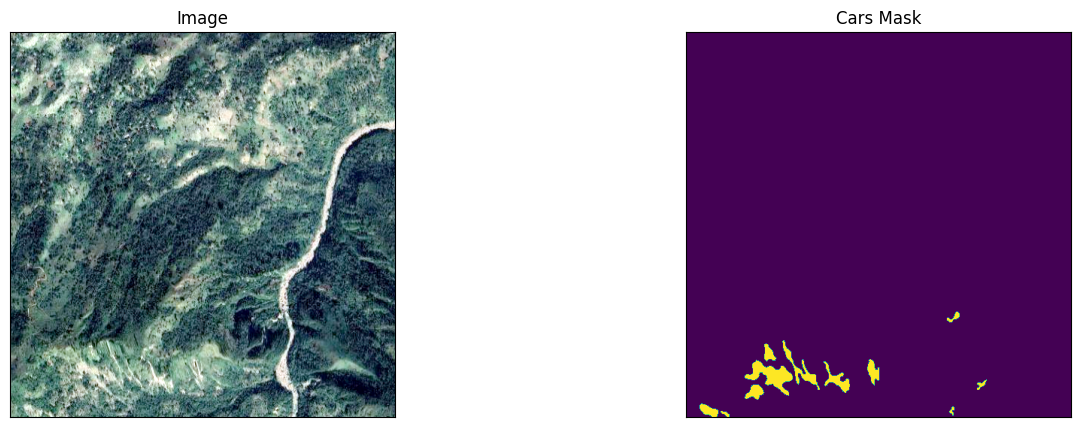

In [8]:
dataset = CAS_Landslide_Dataset(x_train_dir, y_train_dir)
# get some sample
image, mask = dataset[40]
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

In [9]:
BATCH_SIZE = 16

In [10]:
train_dataset = CAS_Landslide_Dataset(
    x_train_dir,
    y_train_dir,
)

valid_dataset = CAS_Landslide_Dataset(
    x_valid_dir,
    y_valid_dir,
)

test_dataset = CAS_Landslide_Dataset(
    x_test_dir,
    y_test_dir,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

## MODEL

In [11]:
os.makedirs("assets", exist_ok=True)

In [12]:
EPOCHS=300
T_MAX = EPOCHS * len(train_loader)

ARCH = "Unet"
ENCODER_NAME = "mobilenet_v2"
ENCODER_WEIGHTS = "imagenet"
IN_CHANNELS = 3
OUT_CLASSES = 1
LEARNING_RATE = 0.001
LOSS_FUNCTION = "FocalLoss"
PATIENCE = 30

In [13]:
def get_loss_fn(loss_name):
    if loss_name == "DiceLoss":
        return smp.losses.DiceLoss(smp.losses.BINARY_MODE, log_loss=False, from_logits=True)
    elif loss_name == "JaccardLoss":
        return smp.losses.JaccardLoss(smp.losses.BINARY_MODE, log_loss=False, from_logits=True)
    elif loss_name == "TverskyLoss":
        return smp.losses.TverskyLoss(smp.losses.BINARY_MODE, log_loss=False, from_logits=True, alpha=0.5, beta=0.5, gamma=1.0)
    elif loss_name == "FocalLoss":
        return smp.losses.FocalLoss(smp.losses.BINARY_MODE, gamma=2.0)
    elif loss_name == "SoftBCE":
        return smp.losses.SoftBCEWithLogitsLoss()
    elif loss_name == "MCCLoss":
        return smp.losses.MCCLoss()
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

In [14]:
class CASLandslideMappingModel(L.LightningModule):
    def __init__(
        self, arch, encoder_name, encoder_weights, in_channels, out_classes, learning_rate, loss_function_name, **kwargs
    ):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        self.learning_rate = learning_rate
        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # get loss function
        self.loss_fn = get_loss_fn(loss_function_name)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        # Metric logging for CSV
        self.metric_log_path = "assets/training_metrics.csv"
        self.logged_metrics = {
            "epoch": [],
            "stage": [],
            "loss": [],
            "per_image_iou": [],
            "dataset_iou": [],
            "f1_score": [],
            "f2_score": [],
            "accuracy": [],
            "recall": [],
            "precision": [],
        }

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score,
            f"{stage}_f2_score": f2_score,
            f"{stage}_accuracy": accuracy,
            f"{stage}_recall": recall,
            f"{stage}_precision": precision,
        }

        self.log_dict(metrics, prog_bar=True)
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()

        # Store current stage metrics
        self.logged_metrics["epoch"].append(self.current_epoch)
        self.logged_metrics["stage"].append(stage)
        self.logged_metrics["per_image_iou"].append(per_image_iou.item())
        self.logged_metrics["dataset_iou"].append(dataset_iou.item())
        self.logged_metrics["f1_score"].append(f1_score.item())
        self.logged_metrics["f2_score"].append(f2_score.item())
        self.logged_metrics["accuracy"].append(accuracy.item())
        self.logged_metrics["recall"].append(recall.item())
        self.logged_metrics["precision"].append(precision.item())
        self.logged_metrics["loss"].append(avg_loss.item())

        # Save just this stage's metrics to CSV
        self.save_epoch_metrics_to_csv()

    def save_epoch_metrics_to_csv(self):
        if not self.logged_metrics["epoch"]:
            return

        df = pd.DataFrame(self.logged_metrics)
        file_exists = os.path.exists(self.metric_log_path)

        if not file_exists:
            df.to_csv(self.metric_log_path, index=False)
        else:
            df.to_csv(self.metric_log_path, mode="a", header=False, index=False)

        # Clear after saving this stage
        for key in self.logged_metrics:
            self.logged_metrics[key].clear()

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10 * 100, eta_min=1e-5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [15]:
model = CASLandslideMappingModel(
            ARCH,
            ENCODER_NAME,
            ENCODER_WEIGHTS,
            IN_CHANNELS,
            OUT_CLASSES,
            LEARNING_RATE,
            LOSS_FUNCTION,
        )

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

## TRAINING

In [16]:
early_stopping = EarlyStopping(
        monitor="valid_dataset_iou",
        mode= "max",
        patience = PATIENCE,
)

In [17]:
trainer = L.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    callbacks=[early_stopping],
    accelerator="gpu",
    default_root_dir="./",
    strategy='ddp_notebook',
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [18]:
# fit the model
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

2025-08-01 15:56:00.401637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754063760.639599     111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754063760.706042     111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_per_image_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_dataset_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_f1_score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_f2_score', ..

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('train_per_image_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('train_dataset_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('train_f1_score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('train_f2_score', ..

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Plotting Training Results

In [19]:
def plot_metrics():
    os.makedirs("assets/plots", exist_ok=True)

    # Load and clean the training metrics
    df = pd.read_csv("assets/training_metrics.csv")
    df = df.iloc[1:].reset_index(drop=True)
    df["epoch"] = df["epoch"].astype(int) + 1

    sns.set(style="whitegrid")
    metrics = [
        "loss",
        "per_image_iou",
        "dataset_iou",
        "f1_score",
        "f2_score",
        "accuracy",
        "recall",
        "precision",
    ]

    for metric in metrics:
        plt.figure(figsize=(10, 5))

        for stage in ["train", "valid"]:
            stage_df = df[df["stage"] == stage]
            plt.plot(stage_df["epoch"], stage_df[metric], label=stage, linewidth=2)

        plt.title(f"{metric.replace('_', ' ').title()} vs Epoch", fontsize=14)
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel(metric.replace("_", " ").title(), fontsize=12)

        # Only show first, middle, and last epoch on the x-axis
        all_epochs = sorted(df["epoch"].unique())
        if len(all_epochs) >= 3:
            first_epoch = all_epochs[0]
            mid_epoch = all_epochs[len(all_epochs) // 2]
            last_epoch = all_epochs[-1]
            plt.xticks([first_epoch, mid_epoch, last_epoch])
        else:
            plt.xticks(all_epochs)

        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"assets/plots/metrics_{metric}.png")
        plt.close()

## Validation

In [20]:
import json

def validate(trainer, model, valid_loader):
    valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=True)

    # Save metrics to a JSON file
    metrics_output_path = "assets/validation_metrics.json"
    os.makedirs(os.path.dirname(metrics_output_path), exist_ok=True)

    with open(metrics_output_path, "w") as f:
        json.dump(valid_metrics, f, indent=4)

    print("Validation metrics saved to", metrics_output_path)

In [21]:
validate(trainer, model, valid_loader)

INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

2025-08-02 01:27:39.395667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754098059.422853  457257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754098059.431238  457257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_per_image_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_dataset_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_f1_score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('valid_f2_score', ..

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      valid_accuracy       │    0.9903149604797363     │
│     valid_dataset_iou     │    0.8818739652633667     │
│      valid_f1_score       │     0.937229573726654     │
│      valid_f2_score       │    0.9373323917388916     │
│    valid_per_image_iou    │    0.7730642557144165     │
│      valid_precision      │    0.9370582103729248     │
│       valid_recall        │     0.846996009349823     │
└───────────────────────────┴───────────────────────────┘

Validation metrics saved to assets/validation_metrics.json


## Testing

In [22]:
def test(trainer, model, test_loader):
    test_metrics = trainer.test(model, dataloaders=test_loader, verbose=True)

    # Save metrics to a JSON file
    metrics_output_path = "assets/test_metrics.json"
    os.makedirs(os.path.dirname(metrics_output_path), exist_ok=True)

    with open(metrics_output_path, "w") as f:
        json.dump(test_metrics, f, indent=4)

    print("Test metrics saved to", metrics_output_path)

In [23]:
test(trainer, model, test_loader)

INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

2025-08-02 01:27:51.031276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754098071.063719  457664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754098071.076545  457664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('test_per_image_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('test_dataset_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('test_f1_score', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('test_f2_score', ..., s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9890348315238953     │
│     test_dataset_iou      │    0.8690222501754761     │
│       test_f1_score       │    0.9299218058586121     │
│       test_f2_score       │    0.9274600744247437     │
│    test_per_image_iou     │    0.7667601108551025     │
│      test_precision       │    0.9340535998344421     │
│        test_recall        │    0.8414661884307861     │
└───────────────────────────┴───────────────────────────┘

Test metrics saved to assets/test_metrics.json


## EVALUATION VISUALIZATION

In [24]:
images, masks = next(iter(test_loader))
with torch.inference_mode():
    model.eval()
    logits = model(images)

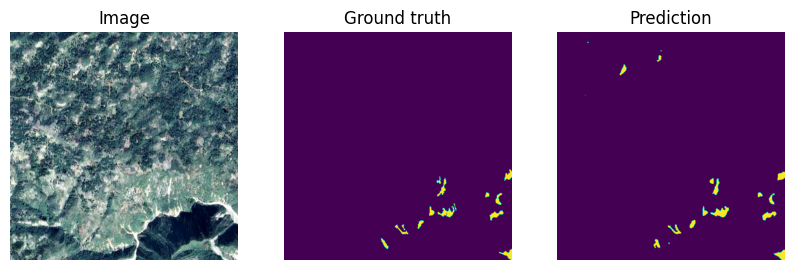

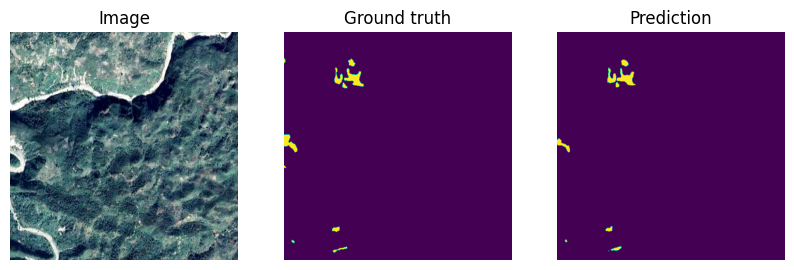

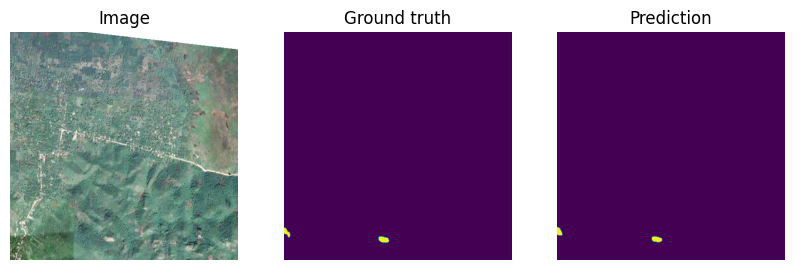

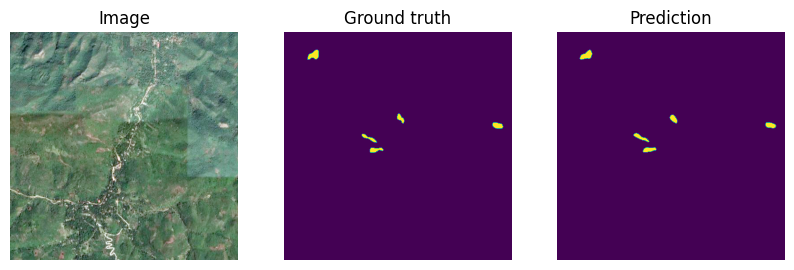

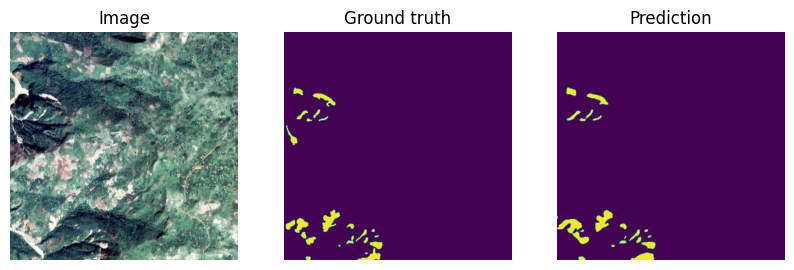

In [25]:
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    # Number of samples visualized
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(np.where(pr_mask.cpu().numpy().squeeze() > 0.5, 255, 0).astype(np.uint8))
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

## SAVING MODEL

In [26]:
MODEL_OUTPUT_PATH = "./CAS_Landslide_Satellite_Unet_mobilenet_v2_FocalLoss"
# save the model
model.model.save_pretrained(MODEL_OUTPUT_PATH, dataset="CAS_landslide_satellite")

# load the model
restored_model = smp.from_pretrained(MODEL_OUTPUT_PATH)

if restored_model:
    print(f"Model is saved")

Loading weights from local directory
Model is saved


## Exporting Model as ONNX

In [27]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 6.31.1 which is incompatible.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=

In [28]:
import onnx
import onnxruntime

onnx_model_output_path = "CAS_Landslide_Satellite_Unet_mobilenet_v2_FocalLoss.onnx"

In [29]:
def check_with_onnx():
    onnx_model = onnx.load(onnx_model_output_path)
    onnx.checker.check_model(onnx_model)


def run_with_onnxruntime():
    input_shape = [1, 3, 512, 512]
    sample = torch.randn(input_shape)
    ort_session = onnxruntime.InferenceSession(
        onnx_model_output_path, providers=["CPUExecutionProvider"]
    )
    ort_inputs = {"input": sample.numpy()}
    ort_outputs = ort_session.run(output_names=None, input_feed=ort_inputs)
    return ort_outputs, sample


def verify_with_pytorch_model(model):
    ort_outputs, sample = run_with_onnxruntime()
    with torch.inference_mode():
        torch_out = model(sample)
    np.testing.assert_allclose(torch_out.numpy(), ort_outputs[0], rtol=1e-03, atol=1e-05)
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [30]:
def export_to_onnx(model):
    input_shape = [1, 3, 512, 512]
    dynamic_axes = {0: "batch_size", 2: "height", 3: "width"}
    torch.onnx.export(
        model,  # model being run
        torch.randn(input_shape),  # model input
        onnx_model_output_path,  # where to save the model (can be a file or file-like object)
        export_params=True,  # store the trained parameter weights inside the model file
        opset_version=17,  # the ONNX version to export
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=["input"],  # the model's input names
        output_names=["output"],  # the model's output names
        dynamic_axes={  # variable length axes
            "input": dynamic_axes,
            "output": dynamic_axes,
        },
    )

In [31]:
# load the model
model = smp.from_pretrained(MODEL_OUTPUT_PATH)
model.eval()

# export to onnx
export_to_onnx(model)

# check with onnx
check_with_onnx()

# run with onnxruntime
run_with_onnxruntime()

# verify it's the same as for pytorch model
verify_with_pytorch_model(model)

Loading weights from local directory
Exported model has been tested with ONNXRuntime, and the result looks good!


In [32]:
! zip -r results.zip ./

  adding: assets/ (stored 0%)
  adding: assets/test_metrics.json (deflated 48%)
  adding: assets/validation_metrics.json (deflated 49%)
  adding: assets/training_metrics.csv (deflated 55%)
  adding: lightning_logs/ (stored 0%)
  adding: lightning_logs/version_2/ (stored 0%)
  adding: lightning_logs/version_2/events.out.tfevents.1754098074.2294ebaffd22.457664.0 (deflated 29%)
  adding: lightning_logs/version_2/hparams.yaml (stored 0%)
  adding: lightning_logs/version_0/ (stored 0%)
  adding: lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: lightning_logs/version_0/checkpoints/epoch=214-step=79980.ckpt (deflated 17%)
  adding: lightning_logs/version_0/hparams.yaml (stored 0%)
  adding: lightning_logs/version_0/events.out.tfevents.1754063771.2294ebaffd22.111.0 (deflated 70%)
  adding: lightning_logs/version_1/ (stored 0%)
  adding: lightning_logs/version_1/hparams.yaml (stored 0%)
  adding: lightning_logs/version_1/events.out.tfevents.1754098062.2294ebaffd22.457257.0 (deflated 